### На примере данного датасета мы посмотрим описательную статистику,  примем несколько решений касательно выбора вина, а также проверим гипотезу о влиянии цены вина на поставленную оценку.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [40]:
sns.set(style='darkgrid', rc={'figure.figsize' : (8,6)})

Уберём дублирующиеся значения, а также повторяющиеся столбцы.

In [41]:
df = pd.read_csv('wine_review.csv')
del df["region_2"]
del df['Unnamed: 0']
df = df.dropna()

In [42]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


### Описание данных 
- *country* - страна-производитель вина;
- *description* - описание вина дегустатором;
- *designation* - название вина, данное производителем;
- *points* - выставленная вину оценка (0-100);
- *price* - цена вина в долларах;
- *province* - регион, где произвели вино;
- *region* - субрегион;
- *taster_name* - имя дегустатора;
- *taster_twitter_handle* - твиттер-аккаунт дегустатора;
- *title* - полное название вина;
- *variety* - название сорта (сортов) винограда;
- *winery* - название винодельни.

---
---
При анализе этого датасета были поставлены следующие задачи:

1) Найти самые частые оценки и среднюю цену вина, соответствующего этим оценкам;

2) Обнаружить дешёвые вина с хорошей оценкой;

3) Выявить вина, которые не только хорошо оцениваются, но и дорого стоят;

4) Определить, существует ли значимая связь между оценкой вина и его ценой.

---
---

Какие оценки ставят чаще всего?

In [43]:
most_common_points = df.groupby('points', as_index=False) \
    .agg({'price': 'count'}) \
    .rename(columns={'price': 'count'}) \
    .sort_values('count', ascending=False) \
    .head()

most_common_points

,points,count
8,88,6958
10,90,6713
7,87,5799
11,91,5668
9,89,5398


Какую оценку в среднем ставят каждой цене? 

In [44]:
avg_points_for_price = df.groupby('price', as_index=False) \
    .agg({'points': 'mean'}) \
    .rename(columns={'points': 'avg_points'}) \
    .sort_values('avg_points', ascending=False)

avg_points_for_price.head(10)

,price,avg_points
272,617.0,100.0
217,259.0,100.0
282,850.0,98.5
220,265.0,98.0
264,520.0,98.0
268,550.0,97.5
270,595.0,97.5
235,305.0,97.5
249,375.0,97.0
261,476.0,97.0


Мы видим, что в среднем дорогие вина (250-620) получают высокие оценки (95+), но даже на примере таблицы, что связь между ценой и оценкой не всегда прямая. Проверим это позже.

---
---
Но что если у нас нет много денег, но мы хотим купить хорошее вино?

Давайте найдём "дешевые" (ниже 25-го перцентиля) вина с хорошей оценкой. Выбор данного перцениля обусловлен исключительно решением автора - при желании "планку" можно понизить.

In [45]:
price_q_25 = df.price.quantile(q=0.25)
cheap_and_good = df.query('price < @price_q_25') \
    .groupby(['title', 'price'], as_index=False) \
    .agg({'points': 'mean'}) \
    .sort_values('points', ascending=False) \

cheap_and_good.head()

,title,price,points
10532,Uvaggio 2010 Secco Moscato Giallo (Lodi),16.0,94.0
9854,Stottle 2011 Lucille Late Harvest Viognier (Ya...,18.0,94.0
3701,D'Arenberg 2008 The Noble Wrinkled Riesling (M...,19.0,94.0
7611,Michael David 2012 Petite Petit Petite Sirah (...,18.0,94.0
8200,Osborne NV Pedro Ximenez 1827 Sweet Sherry She...,14.0,94.0


Получается, можно купить что-то стоящее и за 15 долларов!

Допустим, мы собрались на важный праздник (например, свадьбу) и нам нужно произвести впечатление - подарить не просто вино, а дорогое и вкусное! Попробуем найти такие сорта (возьмём для пример топ-15).

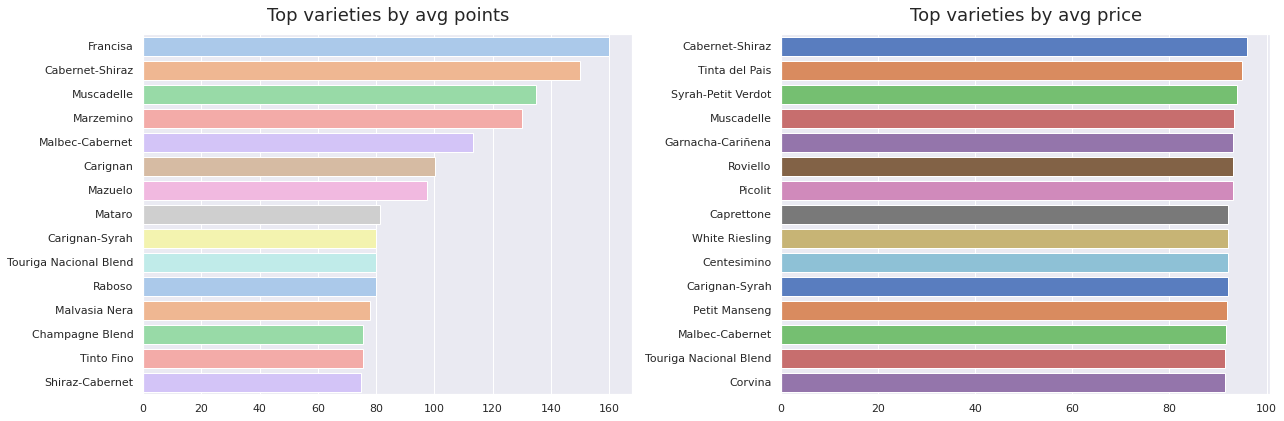

In [46]:
top_varieties = df.groupby('variety', as_index=False) \
    .agg({'points': 'mean'}) \
    .rename(columns={'points': 'avg_points'}) \
    .sort_values('avg_points', ascending=False) \
    .head(15)


variety_top_price_mean = df.groupby('variety', as_index=False) \
                            .agg({'price': 'mean'}) \
                            .rename(columns={'price': 'avg_price'}) \
                            .sort_values('avg_price', ascending=False) \
                            .head(15)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
sns.barplot(y='variety', x='avg_price', data=variety_top_price_mean, ax=ax1, palette='pastel');
ax1.set_title('Top varieties by avg points', fontsize=18, y=1.02)
ax1.set(ylabel=None, xlabel=None)
sns.barplot(y='variety', x='avg_points', data=top_varieties, ax=ax2, palette='muted');
ax2.set_title('Top varieties by avg price', fontsize=18, y=1.02)
ax2.set(ylabel=None, xlabel=None)
plt.tight_layout()

In [47]:
top_varieties.merge(variety_top_price_mean, on='variety')

,variety,avg_points,avg_price
0,Cabernet-Shiraz,96.000000,150.000000
1,Muscadelle,93.250000,135.000000
2,Carignan-Syrah,92.000000,80.000000
3,Malbec-Cabernet,91.666667,113.333333
4,Touriga Nacional Blend,91.500000,80.000000


Берите одно из этих - не прогадаете (скорее всего)!

Но мы также можем ориентироваться на то, какой винодельней оно было сделано. Посмотрим, какие винодельни получают в среднем высокие оценки и какой сорт чаще всего у них пробуют.

In [48]:
top_wineries = df.groupby('winery', as_index=False) \
    .agg({'points': 'mean'}) \
    .rename(columns={'points':'avg_points'}) \
    .sort_values('avg_points', ascending=False) \

df_winery_varieties = df.groupby(['winery', 'variety'], as_index=False) \
    .agg({'country': 'count'}) \
    .pivot(index='winery', columns='variety', values='country').reset_index().fillna(0)

df_wineries = df_winery_varieties.winery
del df_winery_varieties['winery']
df_varieties = df_winery_varieties.idxmax(axis=1)

most_popular_variety_by_winery = pd.concat([df_wineries, df_varieties], axis=1)
most_popular_variety_by_winery = most_popular_variety_by_winery.rename(columns={0: 'top_variety'})

most_popular_variety_by_winery.head()

,winery,top_variety
0,1+1=3,Sparkling Blend
1,100 Percent Wine,Red Blend
2,1000 Stories,Zinfandel
3,12 Linajes,Tempranillo
4,12C Wines,Cabernet Sauvignon


Отлично, осталось только соединить эти две таблицы - и можно использовать её при выборе вина.

In [49]:
winery_points_variety = top_wineries.merge(most_popular_variety_by_winery, on='winery') \
            .sort_values('avg_points', ascending=False)

winery_points_variety.head()

,winery,avg_points,top_variety
0,Baricci,98.000000,Sangiovese
1,Conti Costanti,98.000000,Sangiovese
2,Alpha Omega,97.111111,Cabernet Sauvignon
3,Gianni Brunelli,97.000000,Sangiovese
4,Standish,97.000000,Shiraz


---
---
---
Вернёмся к связи между оценкой и стоимостью вина. Действительно ли эти параметры связаны?

In [50]:
st.spearmanr(df.price, df.points)

SpearmanrResult(correlation=0.6106599247287493, pvalue=0.0)

Согласно <u>шкале Чеддока</u>, корреляция заметная (0.5 - 0.7), а <b>уровень значимости < 0.05 </b> => статистически значимая разница. Взглянем на график:

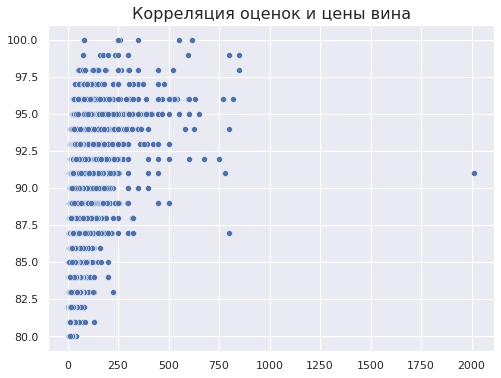

In [51]:
ax = sns.scatterplot(x='price', y='points', data=df);
ax.set(xlabel=None);
ax.set(ylabel=None);
plt.title('Корреляция оценок и цены вина', fontsize = 16);

Получается странный график. Посмотрим на распределение цен:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


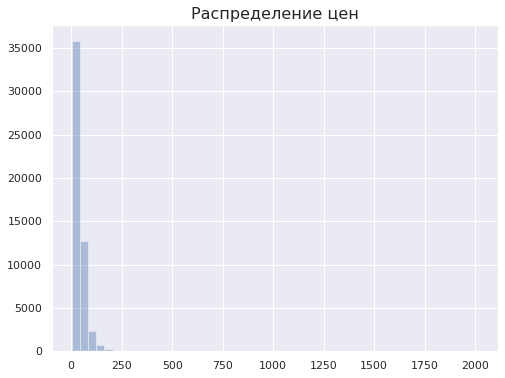

In [52]:
ax = sns.distplot(df.price, kde=False);
ax.set(xlabel=None);
plt.title('Распределение цен', fontsize = 16);

Распределение слабо напоминает нормальное - очень много вин определённой ценовой категории. Прологарфимируем значения.

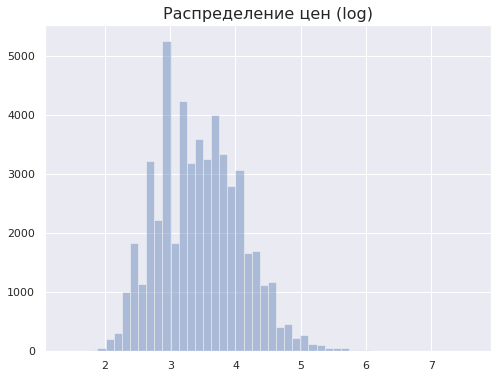

In [53]:
ax = sns.distplot(np.log(df.price), kde=False);
ax.set(xlabel=None);
plt.title('Распределение цен (log)', fontsize = 16);

Теперь распределение больше походит на нормальное, но всё равно не до конца. Что насчёт оценок?

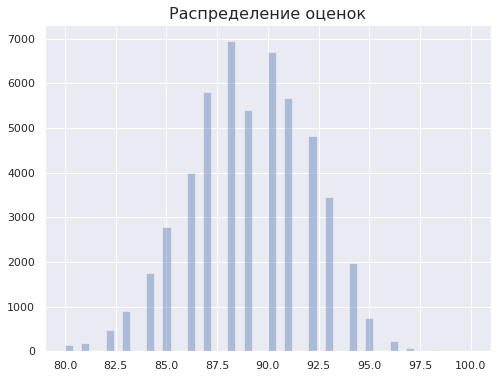

In [54]:
ax = sns.distplot(df.points, kde=False);
ax.set(xlabel=None);
plt.title('Распределение оценок', fontsize = 16);

Более-менее нормальное, но центральные значения проседают. Добавим в датасет пролагорифмированные значения и построим график.

Text(0, 0.5, 'Оценка')

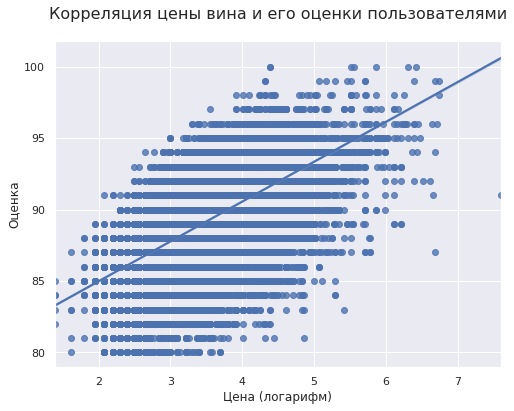

In [55]:
df['price_log'] = np.log(df.price)
df['points_log'] = np.log(df.points)


sns.regplot(x='price_log', y='points', data=df)
plt.title('Корреляция цены вина и его оценки пользователями', fontsize = 16, y= 1.05)
plt.xlabel('Цена (логарифм)')
plt.ylabel('Оценка')

Напишем уравнение линейной регресии:

<b>Y = b0 + b1*X + e</b>

In [56]:
results = smf.ols('points ~ price', df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                 1.340e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        12:23:52   Log-Likelihood:            -1.2457e+05
No. Observations:               52106   AIC:                         2.491e+05
Df Residuals:                   52104   BIC:                         2.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     87.5785      0.017   5129.077      0.0

Несмотря на то, что разница статзначима (<b>P>|t| = 0</b>). Модель объясняет всего <u>20% изменичивости</u> (R-squared). Уравнение принимает следующий вид: <b>points = 87.5785 + 0.0366 * price + standardized_residuals</b>

Проверяем по условиям: 

*1. Связь линейна и монотонна (сделано выше)*;

*2. Остатки распределены нормальным образом*;

*3. Нет выбросов*;

*4. Дисперсия ЗП однородна на всех уровнях НП (гомоскедастичность)*.


---
Посчитаем остатки уравнения регрессии:

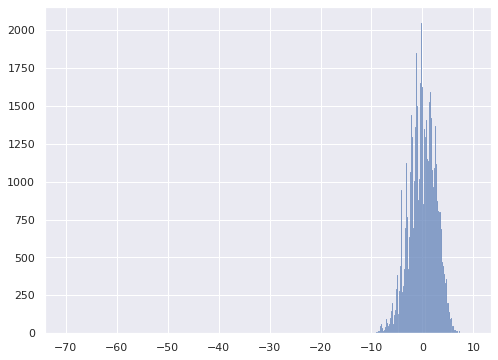

In [57]:
ax = sns.histplot(results.resid);
ax.set(ylabel=None);

Остатки <b>с натяжкой</b> можно назвать нормальными. 

Построим <u>scale-location plot</u> для проверки на гомоскедатичность:

In [58]:
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag

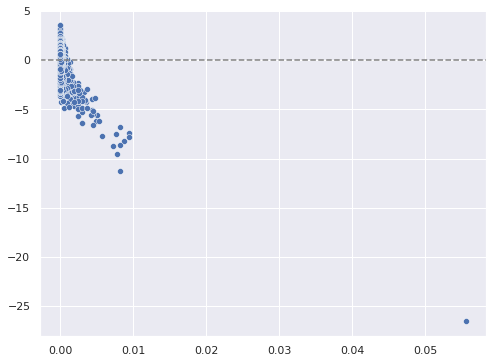

In [59]:
ax = sns.scatterplot(x=leverage, y=stand_resids);
ax.axhline(y=0, color='grey', linestyle='dashed')

Возможно, присутствует граница, которую значения не могут перейти. Скорее всего, это вызвано тем, что минимальная оценка вина - 80. Мы <b>не можем сказать</b>, что дисперсия ЗП однородна на всех уровнях НП. Проверим нормальность распределения остатков также через qq-plot.

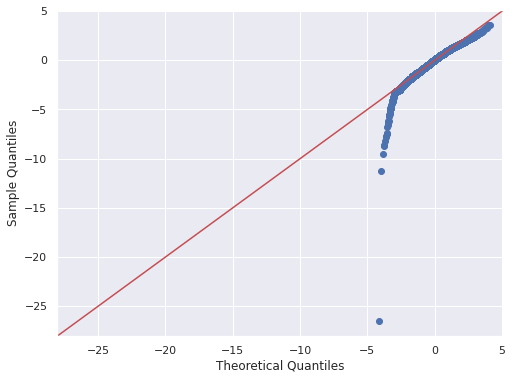

In [60]:
sm.qqplot(residuals, fit=True, line='45', c='#4C72B0');

Есть довольно значимые отклонения по краям, особенно с левой стороны. Распределение <b>нельзя</b> назвать нормальным.

## Выводы

---
1) Найдены самые частые оценки и средняя цена вина, соответствущая этим оценкам;

2) Обнаружены дешёвые вина с хорошей оценкой;

3) Выявлены вина с высокой оценкой и ценой;

4) Мы увидели, что несмотря на заметную корреляцию в 0.6 между ценой и оценкой вина,
качество нашей регрессионной модели довольно низкое - она объясняет только 20% изменчивости (при P>|t| = 0). Проверив нашу модель по условиям применения, мы увидели, что:

- *связь линейна*;
- *остатки распределены относительно нормальным образом*;
- *присутствуют значительные выбросы*;
- *модель гетероскедатична (вероятно, роль играет порог минимальной оценки)*.

Таким образом, мы <b>не можем сказать, что имеется значимая связь между оценкой и ценой</b>.
Для более точной модели требуется дополнительное преобразование данных.